In [123]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from scipy import stats
from scipy.stats import normaltest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from itertools import product

In [89]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [161]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Обычно модели ARCH\GARCH используются  в финансовом секторе, так как под действием внештатных событий могут быть сильные колебания стоимости бумаг. Это выражается в волатильности, то есть переменной дисперсии, когда на разных временных участках могут быть разные значения дисперсии. Для того, чтобы анализировать с помощью моделей семейства ARCH, необходимо, чтобы ряд был стационарен, имел постоянное среднее значение, которое мы рассчитываем с помощью моделей S/ARIMA (для постоянной дисперсии) и пр. 

In [90]:
#преобзразуем кастомизированную дату датамета виде YYYY-Ww в datetime,чтобы потом можно было его поместить в seasonal_decompose 
dowjones_closing['date'] = dowjones_closing['Week'].apply(lambda row: datetime.strptime(row+'-1', '%Y-W%W-%w'))

In [102]:
df = dowjones_closing[['date','Close']].set_index('date')
df.sort_index(inplace=True)

Посмотрим на наличие составляющих (тренд, сезонность) временного ряда. Присутствуют и тренд и сезонность

In [106]:
seasonal_dec = seasonal_decompose(df, period = 7)

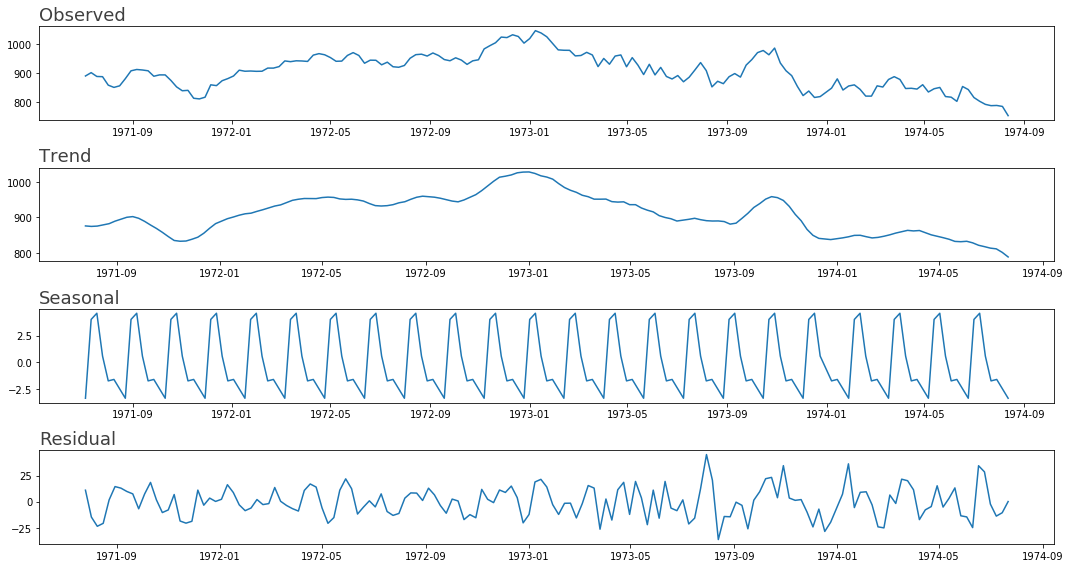

In [107]:
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

plt.subplot(411)
plt.plot(df['Close'], label="Original")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

In [191]:
# похоже сезонность 14
seasonal_dec.seasonal[:15]

date
1971-07-05   -3.358333
1971-07-12    4.005369
1971-07-19    4.582317
1971-07-26    0.582613
1971-08-02   -1.736145
1971-08-09   -1.601320
1971-08-16   -2.474501
1971-08-23   -3.358333
1971-08-30    4.005369
1971-09-06    4.582317
1971-09-13    0.582613
1971-09-20   -1.736145
1971-09-27   -1.601320
1971-10-04   -2.474501
1971-10-11   -3.358333
Name: seasonal, dtype: float64

Проверим является ли ряд стационарнм. Так как присутствуют и тренд и сезонность, попробуем проанализировать ряд на стационарность и проанализировать кореллограммы.
Как видим из теста ДФ ряд не стационарен (0.62 > 0.05). Также это видно на медленно спадающих значениях лагом на ACF. 

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


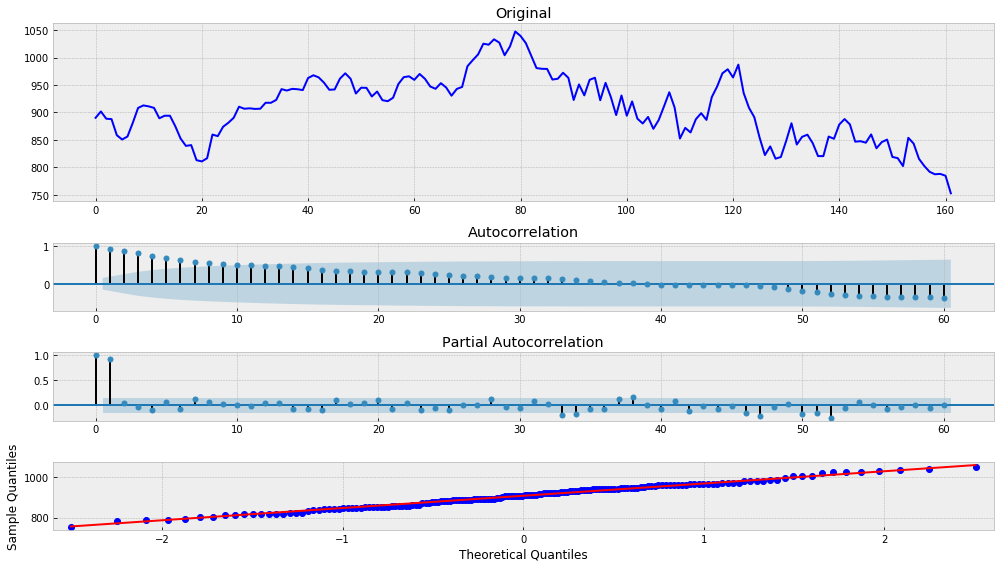

In [135]:
tsplot(dowjones_closing['Close'], lags = 60)

Попробуем провести дифференцирование и проверить ряд на стационарность. Ряд стационарен, о чем говорит тест ДФ, а также отсутствие корелляций, выходящию за доверительный интервал, а также QQ плот показывает близкое к идеальному нормальное распрделение

In [117]:
diff1 = np.diff(dowjones_closing['Close'])

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


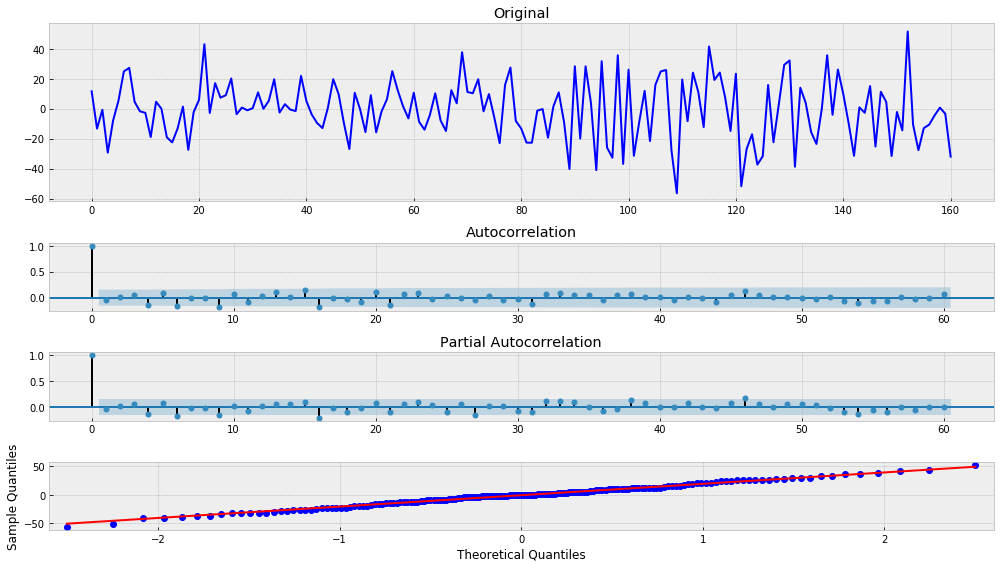

In [134]:
tsplot(diff1, lags = 60)

По сути дифференцированный - это по сути график изенений цены, то есть ряд с постоянной средней (остутствует тренд) и  переменной дисперсией, что видно из графика: есть часть с низкой дисперсией (20- 80) и ряд с более высокой дисперсией (90 - 160). Попробуем тут построить модель GARCH и оценить эти изменения для дисперсии (волатильности). Построим прогноз для 100 значений. из отчета модели видно, что значение среднего близко к нуля и значимо, коэффициенты альфа и бета значимы, а вот омега нет значима. AIC = 1414

In [276]:
garch_dj_diff = arch_model(diff1, p = 1, q = 1, dist='StudentsT', vol = "GARCH").fit(update_freq = 5)
fc_garch_dj_diff = garch_dj_diff.forecast(horizon = 170, reindex=True, start = 0)
garch_dj_diff.summary()

Iteration:      5,   Func. Count:     36,   Neg. LLF: 703.2337902919562
Iteration:     10,   Func. Count:     66,   Neg. LLF: 702.5830134843138
Iteration:     15,   Func. Count:     96,   Neg. LLF: 702.4577973087255
Iteration:     20,   Func. Count:    126,   Neg. LLF: 702.3181043801827
Iteration:     25,   Func. Count:    158,   Neg. LLF: 702.3295862161276
Optimization terminated successfully    (Exit mode 0)
            Current function value: 702.3022945779786
            Iterations: 25
            Function evaluations: 168
            Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -702.302
Distribution:      Standardized Student's t   AIC:                           1414.60
Method:                  Maximum Likelihood   BIC:                           1430.01
                                              No. Observations:                  161
Date:                      Mon, Aug 16 2021   Df Residuals:                      160
Time:                              18:12:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1405      1.423  9.875e-02      0.921 [ -2.648,  2.929]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          6.2770      6.156      1.020      0.308   [ -5.789, 18.343]
alpha[1]       0.0592  2.130e-02      2.778  5.465e-03 [1.743e-02,  0.101]
beta[1]        0.9288  2.633e-02     35.276 1.353e-272   [  0.877,  0.980]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu           128.0697     70.008      1.829  6.735e-02 [ -9.144,2.653e+02]
==========================================================================

Covariance estimator: robust
"""

Построим график изменений цены diff и на основе модели garch ее волатильность. из графика видно, что волатильность повторяет форму пиков изменений цены. Волатильность носит скорее оценивающий характер, нежели предсказательный, хотя предскахывать тоже можно. Несколько значений на графике для СКО оранжевым показывают это.

In [288]:
rolling_pedictions = []
test_size = len(diff1) -1
for i in range(test_size):
    train = diff1[: -(test_size-i)]
    modelarch = arch_model(train, p = 1, q = 1).fit(disp = 'off')
    fc_r = modelarch.forecast(horizon = 1)
    rolling_pedictions.append(np.sqrt(fc_r.variance.values[-1:][0]))
    

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\univariate\volatility.py:1188: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWa

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will chan

C:\Users\Vladimir\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


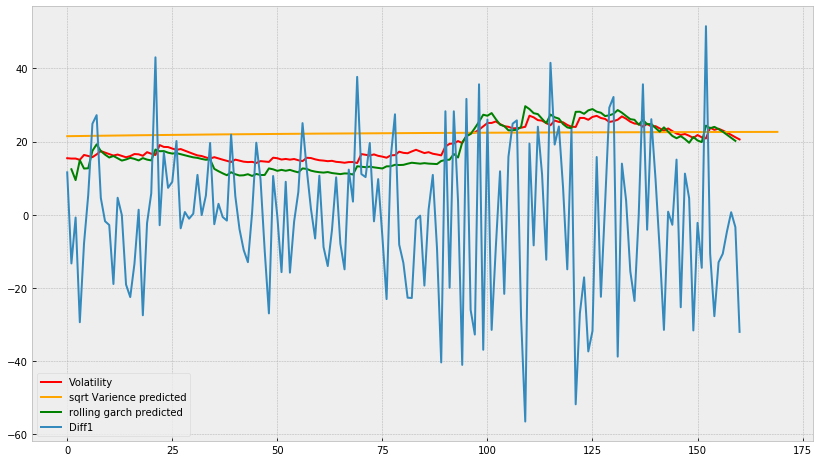

In [289]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    plt.plot(garch_dj_diff.conditional_volatility, label = 'Volatility', color = 'red')
    plt.plot(np.sqrt(fc_garch_dj_diff.variance.values[-1,:]), label = 'sqrt Varience predicted', color = 'orange')
    plt.plot(rolling_pedictions, color = 'green', label = 'rolling garch predicted')
    plt.plot(diff1, label = 'Diff1')
    plt.legend()
    plt.show()
#fc_garch_dj_diff.variance.values[-1,:] - выбирает последнюю строку в датасете для H1, H2, и пр (количесвтво, указано в horizon)

Никаких явных корелляций по лагам нет, поэтому и по-хорошему можно использовать параметры p=1, q=1. Ряд стационарен.

Results of Dickey-Fuller Test:
Test Statistic                  -5.501346
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


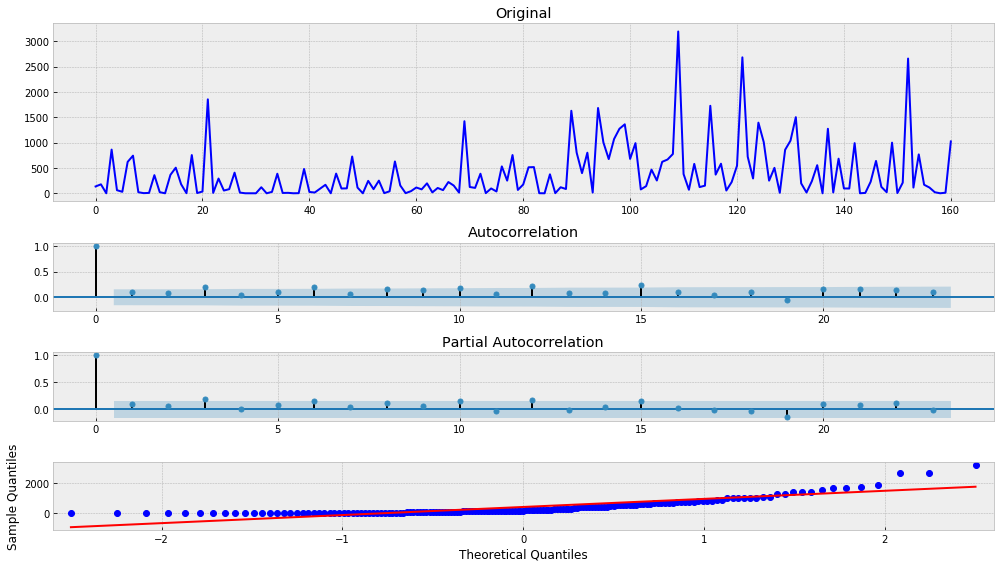

In [248]:
tsplot(diff1**2)

In [282]:
 np.sqrt(fc_garch_dj_diff.variance.values[-1,:])

array([21.48930622, 21.50597932, 21.52243898, 21.53868812, 21.55472957,
       21.57056617, 21.58620068, 21.60163583, 21.61687431, 21.63191878,
       21.64677183, 21.66143605, 21.67591396, 21.69020806, 21.70432082,
       21.71825464, 21.73201192, 21.74559502, 21.75900624, 21.77224787,
       21.78532216, 21.79823134, 21.81097758, 21.82356304, 21.83598984,
       21.84826008, 21.86037581, 21.87233908, 21.88415188, 21.8958162 ,
       21.90733397, 21.91870712, 21.92993755, 21.9410271 , 21.95197764,
       21.96279096, 21.97346887, 21.98401311, 21.99442543, 22.00470755,
       22.01486115, 22.0248879 , 22.03478944, 22.0445674 , 22.05422337,
       22.06375893, 22.07317563, 22.08247501, 22.09165858, 22.10072782,
       22.10968422, 22.11852921, 22.12726424, 22.13589071, 22.14441001,
       22.15282352, 22.16113259, 22.16933856, 22.17744274, 22.18544644,
       22.19335094, 22.2011575 , 22.20886737, 22.21648178, 22.22400195,
       22.23142908, 22.23876435, 22.24600892, 22.25316395, 22.26

Попробуем построить оптимальную модель семейства ARIMA и сравнить результаты. В результате по остаткам видим, что присутствует небольшое смещение вправо относительно нуля эталонного нормального распределения и вытянуто. Также хвосты не очень ложатся. Все корреляции на кореллограме в доверительном интервале. Что говорит нам, что распределение остатков очень похоже на белый шум и можно на этом остановиться в оптимизации модели.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[14]             : AIC=1397.623, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[14]             : AIC=1399.300, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[14]             : AIC=1359.096, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[14]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[14]             : AIC=1395.892, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[14]             : AIC=1348.547, Time=0.51 sec
 ARIMA(1,1,0)(2,1,1)[14]             : AIC=inf, Time=2.31 sec
 ARIMA(1,1,0)(1,1,1)[14]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(2,1,0)[14]             : AIC=1347.070, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[14]             : AIC=1358.183, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[14]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(1,1,1)[14]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[14]             : AIC=1348.618, Time=0.45 sec
 ARIMA(1,1,1)(2,1,0)[14]             : AIC=1350.426, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[14] intercept   : AIC=1

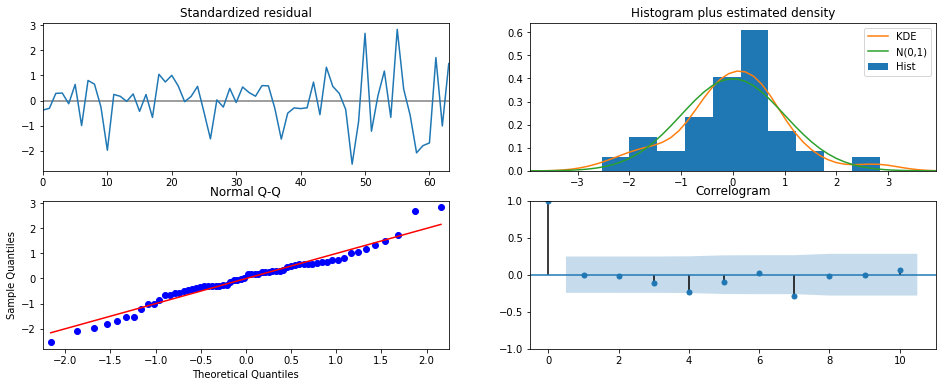

In [193]:
model = pm.auto_arima(dowjones_closing['Close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=14,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      start_Q=0,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_man2)
arima_man2.plot_diagnostics(figsize=(16,6))
plt.show()

In [199]:
model_man = SARIMAX(dowjones_closing['Close'], order=(0,1,0), seasonal_oder = (2,1,0,14)).fit(trend='nc')

In [202]:
model_man.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  162
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -709.224
Date:                Mon, 16 Aug 2021   AIC                           1420.447
Time:                        10:48:27   BIC                           1423.529
Sample:                             0   HQIC                          1421.699
                                - 162                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       392.4389     44.934      8.734      0.000     304.371     480.507
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.59   Prob(JB):                         0.85
Heteroskedasticity (H):               2.84   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

модель хорошо предсказывает существующий ряд, но не может предсказать дальше, так как не понятен ни тренд, ни сезонность.

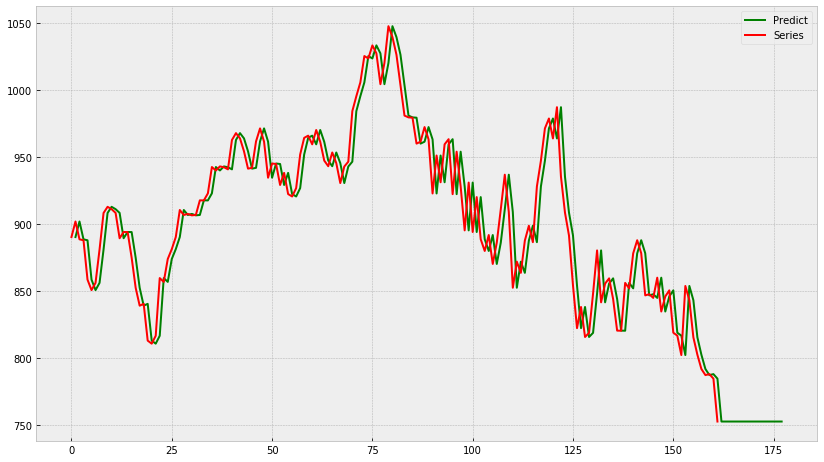

aic: 1420.44736


In [201]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(model_man.predict(start = 1, end = len(dowjones_closing['Close'])+15), color='green', label='Predict')
    plt.plot(dowjones_closing['Close'], color='red', label='Series')
    plt.legend()
    plt.show()
print('aic: {:6.5f}'.format(model_man.aic))

Посмотрим на отличие от остатков модели ARIMA и один раз дифференцированный ряд.  они почти совпали. поэтому по сути дальнейшие манипуляции с остатками по сути идентичны тому, что мы делали с дифференцированным рядом и моделью Garch 

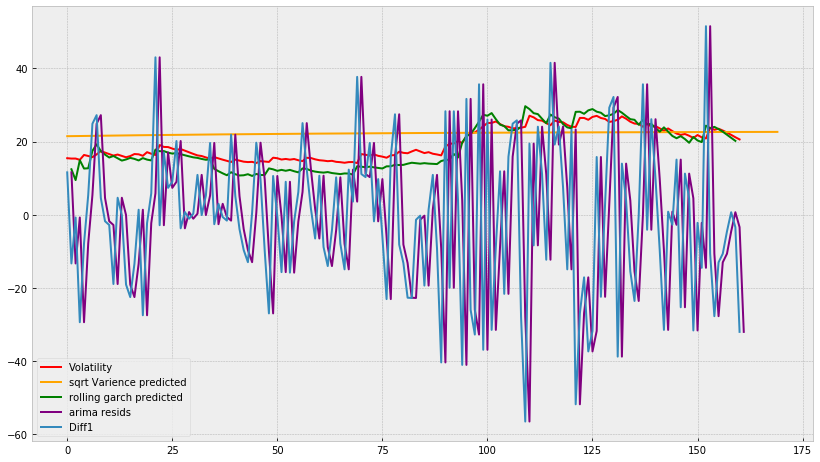

In [294]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    plt.plot(garch_dj_diff.conditional_volatility, label = 'Volatility', color = 'red')
    plt.plot(np.sqrt(fc_garch_dj_diff.variance.values[-1,:]), label = 'sqrt Varience predicted', color = 'orange')
    plt.plot(rolling_pedictions, color = 'green', label = 'rolling garch predicted')
    plt.plot(model_man.resid[1:], color = 'purple', label = 'arima resids')
    plt.plot(diff1, label = 'Diff1')
    plt.legend()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


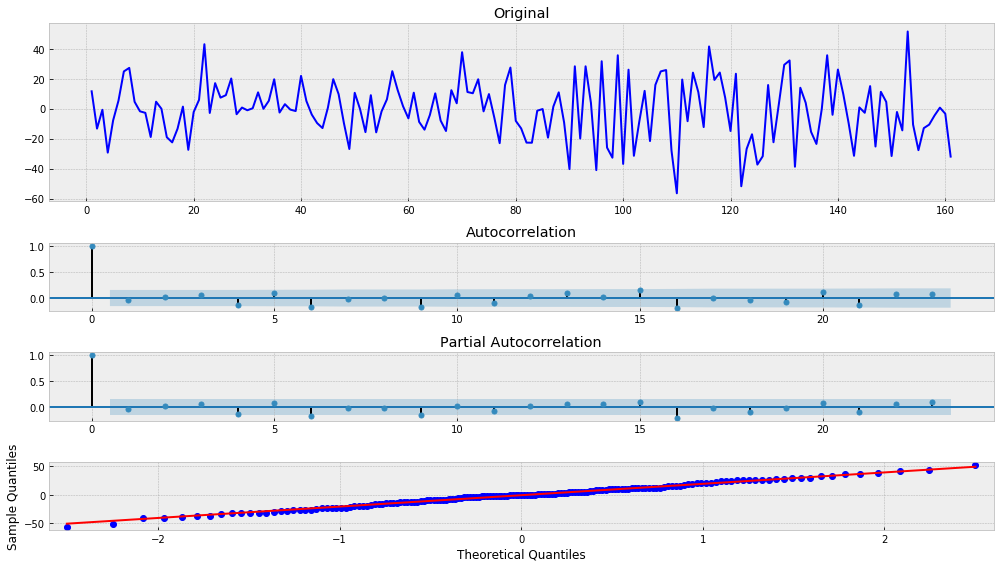

In [203]:
tsplot(model_man.resid[1:])

Попробуем предсказать вариативность остатков с помощью метода GARCH для остатков модели ARIMA

In [229]:
garch_dj_resid = arch_model(model_man.resid[1:], p = 1, q = 1, dist='StudentsT', vol = "GARCH").fit(update_freq = 5)
fc_garch_dj_resid = garch_dj_resid.forecast(horizon = 100, reindex=False, start = 0)
garch_dj_resid.summary()

Iteration:      5,   Func. Count:     36,   Neg. LLF: 703.233789112848
Iteration:     10,   Func. Count:     66,   Neg. LLF: 702.5830798094837
Iteration:     15,   Func. Count:     96,   Neg. LLF: 702.4577840642305
Iteration:     20,   Func. Count:    126,   Neg. LLF: 702.3089369690404
Iteration:     25,   Func. Count:    166,   Neg. LLF: 702.2849131430927
Iteration:     30,   Func. Count:    196,   Neg. LLF: 702.2845550560422
Optimization terminated successfully    (Exit mode 0)
            Current function value: 702.284554741127
            Iterations: 30
            Function evaluations: 206
            Gradient evaluations: 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -702.285
Distribution:      Standardized Student's t   AIC:                           1414.57
Method:                  Maximum Likelihood   BIC:                           1429.98
                                              No. Observations:                  161
Date:                      Mon, Aug 16 2021   Df Residuals:                      160
Time:                              13:21:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1202      1.421  8.455e-02      0.933 [ -2.665,  2.905]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          6.6193      6.454      1.026      0.305   [ -6.031, 19.269]
alpha[1]       0.0592  2.115e-02      2.801  5.099e-03 [1.778e-02,  0.101]
beta[1]        0.9278  2.698e-02     34.390 3.524e-259   [  0.875,  0.981]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu           174.1876     99.957      1.743  8.140e-02 [-21.725,3.701e+02]
==========================================================================

Covariance estimator: robust
"""

Results of Dickey-Fuller Test:
Test Statistic                  -1.274650
p-value                          0.640689
#Lags Used                       0.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


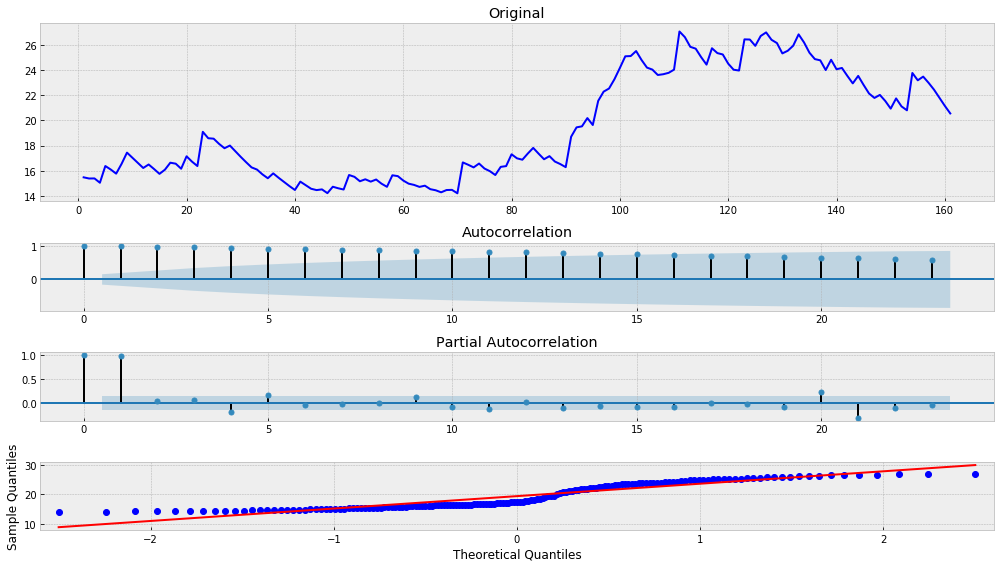

In [214]:
tsplot(garch_dj_resid.conditional_volatility)

In [227]:
fc_garch_dj_resid.variance.iloc[0].reset_index()
fc_garch_dj_orig.variance.iloc[0].reset_index()[0]

0     855.441836
1    1138.140635
2    1413.224256
3    1680.897831
4    1941.360967
5    2194.807896
6    2441.427616
7    2681.404035
8    2914.916105
9    3142.137961
Name: 0, dtype: float64

In [231]:
garch_dj_orig = arch_model(dowjones_closing['Close'], p = 1, q = 1, dist='StudentsT', vol = "GARCH").fit(update_freq = 5)
fc_garch_dj_orig = garch_dj_orig.forecast(horizon = 100, reindex=False, start = 0)
garch_dj_orig.summary()

Iteration:      5,   Func. Count:     32,   Neg. LLF: 859.2653148066375
Iteration:     10,   Func. Count:     62,   Neg. LLF: 857.163393339086
Iteration:     15,   Func. Count:     92,   Neg. LLF: 855.4306111846597
Iteration:     20,   Func. Count:    125,   Neg. LLF: 855.0970123910483
Iteration:     25,   Func. Count:    155,   Neg. LLF: 855.0597202848344
Iteration:     30,   Func. Count:    187,   Neg. LLF: 854.8357242787904
Iteration:     35,   Func. Count:    218,   Neg. LLF: 854.2165449157542
Optimization terminated successfully    (Exit mode 0)
            Current function value: 854.2165449160777
            Iterations: 36
            Function evaluations: 234
            Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -854.217
Distribution:      Standardized Student's t   AIC:                           1718.43
Method:                  Maximum Likelihood   BIC:                           1733.87
                                              No. Observations:                  162
Date:                      Mon, Aug 16 2021   Df Residuals:                      161
Time:                              13:21:33   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           908.8943     18.045     50.367      0.000 [8.735e+02,9.443e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        305.7422    284.377      1.075      0.282 [-2.516e+02,8.631e+02]
alpha[1]       0.8356      0.101      8.291  1.125e-16      [  0.638,  1.033]
beta[1]        0.1375      0.143      0.960      0.337      [ -0.143,  0.418]
                                Distribution                                
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
nu           497.8825     39.162     12.714  4.973e-37 [4.211e+02,5.746e+02]
============================================================================

Covariance estimator: robust
"""